# Optimizing the KSD

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import svgd

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Define Kernels

In [2]:
def get_rbf_fn(bandwidth):
    logh = np.asarray(bandwidth)
    logh = np.squeeze(bandwidth)
    def rbf(x, y): 
        x, y = np.asarray(x), np.asarray(y)
        return np.exp(- np.sum((x - y)**2 / bandwidth**2) / 2)
    return rbf

# other kernels for comparison
def get_tophat_fn(bandwidth):
    def tophat(x, y): return np.squeeze(np.where(np.linalg.norm(x-y)<bandwidth, 1., 0.))
    return tophat

def constant(x, y): return np.array(1.)

def funnelize(v):
    """If v is standard 2D normal, then
    funnelize(v) is distributed as Neal's Funnel."""
    x, y = v
    return np.append(x*np.exp(3*y/2), 3*y)

def defunnelize(z):
    """Inverse of funnelize."""
    x, y = z
    return np.append(x*np.exp(-y/2), y/3)

def get_funnel_fn(bandwidth):
    rbf = get_rbf_fn(bandwidth)
    def funnel_kernel(x, y):
        return rbf(defunnelize(x), defunnelize(y))
    return funnel_kernel

## Build Optimizer

In [3]:
class KSDLearner():
    def __init__(self, key, sizes, activation_kernel, proposal, target, learning_rate: float):
        self.sizes = sizes
        self.activation_kernel = activation_kernel
        self.proposal = proposal
        self.target = target
        
        # net and optimizer
        self.mlp = kernels.build_mlp(self.sizes, name="MLP", skip_connection=False)
        self.opt = svgd.Optimizer(*optimizers.adam(learning_rate))
        self.step = 0
        self.losses = []
        self.initialize_optimizer(key)
            
    def initialize_optimizer(self, key):
        # initialize optimizer
        x_dummy = np.ones(self.proposal.d)
        key, subkey = random.split(key)
        init_params = self.mlp.init(subkey, x_dummy)
        self.optimizer_state = self.opt.init(init_params)
        return None
    
    def get_kernel_fn(self, params):
        def kernel(x, y):
            x, y = np.asarray(x), np.asarray(y)
            return self.activation_kernel(self.mlp.apply(params, None, x), 
                                          self.mlp.apply(params, None, y))
        return kernel

    def loss_fn(self, params, samples):
        kernel = self.get_kernel_fn(params)
        ksd = stein.ksd_squared_u(samples, self.target.logpdf, kernel, False)
        return -ksd

    @partial(jit, static_argnums=0)
    def update_step(self, optimizer_state, samples, step: int):
        # update step
        params = self.opt.get_params(optimizer_state)
        loss, g = value_and_grad(self.loss_fn)(params, samples)
        optimizer_state = self.opt.update(step, g, optimizer_state)
        return optimizer_state, loss
        
    def train(self, n_steps=100, n_samples=400):
        for _ in tqdm(range(n_steps)):
            self.step += 1
            samples = proposal.sample(n_samples)
            self.optimizer_state, loss = self.update_step(self.optimizer_state, samples, self.step)
            self.losses.append(loss)
        return None
    
    @partial(jit, static_argnums=0)    
    def estimate_ksd_squared(self, params):
        k = self.get_kernel_fn(params)
        ksd = stein.ksd_squared_u(samples, self.target.logpdf, k, False)
        
    def compute_final_loss_mean_and_stddev(self):
        loss_tail = self.losses[-50:]
        return onp.mean(loss_tail), onp.std(loss_tail)

In [4]:
# estimate KSD and Var(\hat KSD) values for base kernels
def estimate_ksd_and_stddev(n: int, m: int, kernels, proposal, target):
    """
    n: number of particles
    m: number of draws for variance estimation
    kernels: list of kernel functions
    
    Returns
    ksds: mean ksd value for each kernel
    stds: standard dev for each kernel
    """
    ksds_list = [[] for kernel in kernels]
    for _ in tqdm(range(m)):
        samples = proposal.sample(n)
        for kernel_ksds, kernel in zip(ksds_list, kernels):
            ksd = stein.ksd_squared_u(samples, target.logpdf, kernel, False)
            kernel_ksds.append(ksd)
    
    ksds = onp.mean(ksds_list, axis=1)
    stds = onp.std(ksds_list, axis=1)
    return ksds, stds

#### Plot everything

In [5]:
def plot_training(losses, ksds, stds, ax=None, lims=None):
    if ax is None:
        ax = plt.gca()
    grid_ksds = -np.asarray(learner.losses)
    ax.plot(grid_ksds, "--k", label="Optimized KSD")

    labels = ("k(x, y)=1 constant", "RBF with bandwidth 1", "RBF composed with funnel")
    cycle = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for label, ksd, std, errorbar_xpos in zip(labels, ksds, stds, len(grid_ksds)*np.array([1/3, 2/3, 0.9])):
        col = next(cycle)
        ax.axhline(y=ksd, label=label, color=col, linestyle="--")
        ax.errorbar(errorbar_xpos, ksd, yerr=std, color=col, capsize=5, label="Standard deviation")
    ax.set_xlabel("Steps")
    ax.set_ylabel("KSD")

    ax.set_ylim(lims)
    _ = ax.legend()

### Parameters

In [6]:
proposal = metrics.FunnelizedGaussian([1, 1], 1)
target = metrics.Funnel(2)
sizes = [32, 32, 32, 2]

### Train

In [7]:
print("Training kernel to optimize KSD...")
learner = KSDLearner(key, sizes, get_rbf_fn(1), proposal, target, 0.01)
learner.train(200)
loss_mean, loss_std = learner.compute_final_loss_mean_and_stddev()

Training kernel to optimize KSD...


100%|██████████| 200/200 [01:18<00:00,  2.56it/s]


In [8]:
print("Computing KSDs with base kernels for comparison...")
kernel_list = [constant, get_rbf_fn(1)]
if isinstance(target, metrics.Funnel):
    kernel_list.append(get_funnel_fn(1))
ksds, stds = onp.array(estimate_ksd_and_stddev(400, 15, kernel_list, 
                                              proposal, target))

  0%|          | 0/15 [00:00<?, ?it/s]

Computing KSDs with base kernels for comparison...


100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


Plot results:


<ErrorbarContainer object of 3 artists>

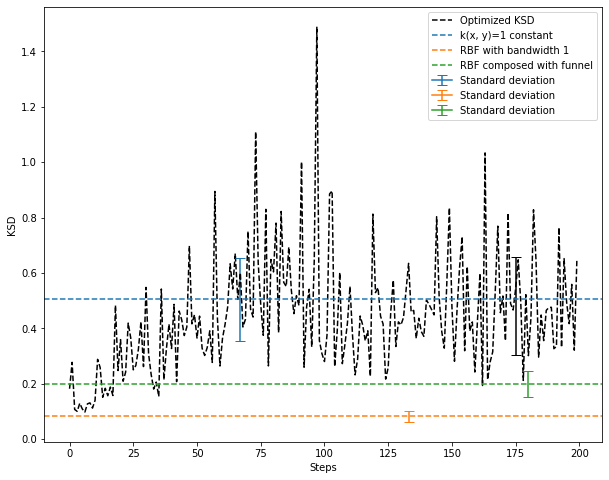

In [9]:
print("Plot results:")
fig, ax = plt.subplots(figsize=[10,8])
plot_training(learner.losses, ksds, stds, ax)
_ = ax.errorbar(len(learner.losses)-25, -loss_mean, yerr=loss_std, capsize=5, color="k")

In [10]:
learned_kernel = learner.get_kernel_fn(learner.opt.get_params(learner.optimizer_state))

In [12]:
s = proposal.sample(100)

In [14]:
learned_kernel(s[0], s[40])

DeviceArray(0.9997842, dtype=float32)

# Sanity Check
In theory, if $k$ is the constant kernel $k(x, y) = 1$, then 
KSD rel to $k$ should be equal to 
$\Vert \phi^* \Vert$
where $\phi^* = E_{x \sim q}[\nabla \log p(x)] \in \mathbb R^d$.

So KSD squared is equal to $\Vert \phi^* \Vert^2$.

In [44]:
dlogp = grad(target.logpdf)

In [58]:
def h_theory(x, y):
    return np.inner(dlogp(x), dlogp(y))

def h(x, y):
    def inner(x):
        kx = lambda y_: np.array(1.)
        return stein.stein_operator(kx, y, target.logpdf)
    return stein.stein_operator(inner, x, target.logpdf, transposed=True)

In [99]:
x, y = proposal.sample(2)
h_theory(x, y) == h(x, y)

DeviceArray(True, dtype=bool)

In [75]:
n = 400
m = 15
estimate_ksd_and_stddev(n, m, (constant,), proposal, target)

100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


(array([0.546727], dtype=float32), array([0.17269458], dtype=float32))

In [98]:
samples = proposal.sample(100000)
exp_grad_log = np.mean(vmap(dlogp)(samples), axis=0)
print(np.linalg.norm(exp_grad_log)**2)

0.50280446
